In [51]:
import os
import pandas
import shutil
import pathlib
from datasets.utils import TMP_DIR

In [52]:
current_path = pathlib.Path('.').absolute()

In [53]:
black_women = list(os.walk(TMP_DIR / 'black'))

white_women = list(os.walk(TMP_DIR / 'white'))

In [54]:
temp_destination_folder = TMP_DIR / 'faces'

Analyse the images from the dataset in order to get certain details useful for machine learning

In [55]:
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
import cv2

In [56]:
def get_dominant_colors(path):
    image = Image.open(path).convert('RGB')
    image = image.resize((100, 100))

    meta = np.array(image).reshape(-1, 3)

    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans.fit(meta)
    colors = kmeans.cluster_centers_.astype(int)
    return ['#{:02x}{:02x}{:02x}'.format(*color) for color in colors]

In [57]:
def get_color_histogram(path):
    image_bgr = cv2.imread(path)

    if image_bgr is None:
        raise ValueError("Image not found at the specified path.")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    h_channel, s_channel, v_channel = cv2.split(image_hsv)
    return [h_channel, s_channel, v_channel]
    

In [58]:
def rename_and_copy(prefix, items, copy_files=True):
    images_container = []

    ethnicity = 'Black' if prefix == 'b' else 'White'

    root, dirs, files = items[0]
    root = pathlib.Path(root)

    for i, file in enumerate(files):
        path = root.joinpath(file)
        filename = f'{prefix}-face-{i + 1}{path.suffix}'
        
        if copy_files:
            shutil.copy2(path, temp_destination_folder.joinpath(filename))

        # Image analysis
        colors = get_dominant_colors(path)
        # color_histogram = get_color_histogram(path)

        images_container.append({
            'name': filename, 
            'ethnicity': ethnicity,
            'dominant_colors': colors,
            # 'hsv': color_histogram
        })

    return images_container

In [59]:
data1 = rename_and_copy('b', black_women, copy_files=True)

In [60]:
data2 = rename_and_copy('w', white_women, copy_files=True)

In [61]:
df1 = pandas.DataFrame(data1)
df2 = pandas.DataFrame(data2)

In [62]:
df = pandas.concat([df1, df2])

## Explore data

In [63]:
df.head(n=10)

,name,ethnicity,dominant_colors
0,b-face-1.jpg,Black,"[#1f1819, #795437, #a8896e, #dc2c2a, #4e5363]"
1,b-face-2.jpg,Black,"[#323c41, #ad917d, #8c6446, #643922, #12181b]"
2,b-face-3.jpg,Black,"[#482f26, #fcfcfc, #9e776d, #764a3a, #1b1513]"
3,b-face-4.jpg,Black,"[#795648, #d8a07b, #f7f4f5, #372d2d, #b67d5c]"
4,b-face-5.jpg,Black,"[#120d0b, #ad6849, #d1896b, #7a452d, #efad90]"
5,b-face-6.jpg,Black,"[#543d3a, #171316, #bed0da, #6c6163, #332628]"
6,b-face-7.jpg,Black,"[#6c5043, #d9cec6, #d2a686, #1c1612, #ab7e65]"
7,b-face-8.jpg,Black,"[#b1b0a7, #8d5b32, #a6805d, #201914, #5f3d22]"
8,b-face-9.jpg,Black,"[#773e41, #d1a2c3, #5b281b, #100808, #a26c6c]"
9,b-face-10.jpg,Black,"[#baa48f, #6b4e42, #e8e6df, #27211d, #967865]"


In [64]:
from matplotlib import pyplot as plt

In [65]:
face_by_ethnicity = df.groupby('ethnicity')['name'].count()

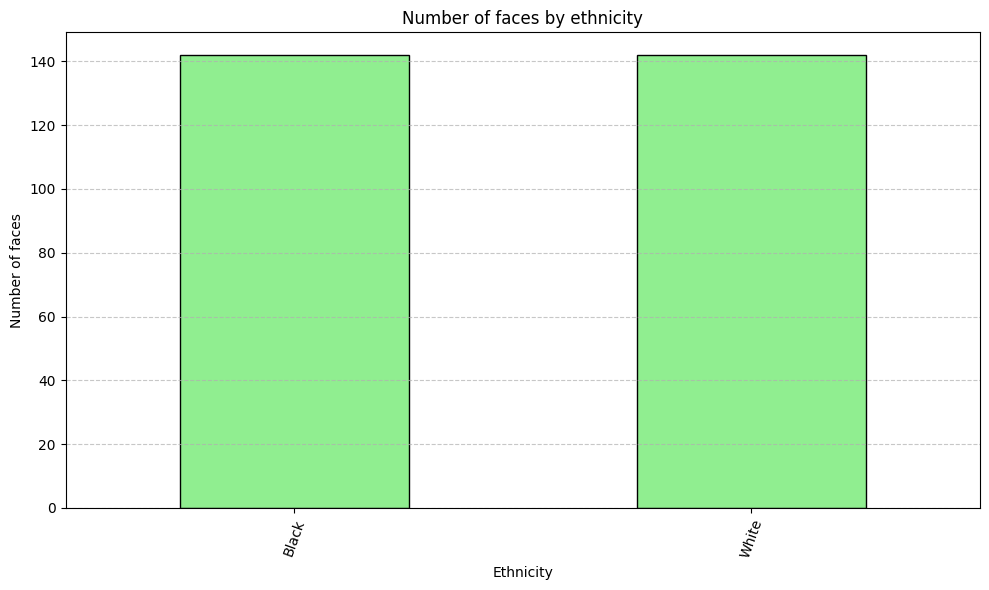

In [66]:
plt.figure(figsize=(10, 6))

ax = face_by_ethnicity.plot(kind='bar', color='lightgreen', edgecolor='black')

plt.title('Number of faces by ethnicity')

plt.xlabel('Ethnicity')
plt.ylabel('Number of faces')

plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)

params = {'ha': 'center', 'va': 'center'}

plt.tight_layout()
plt.show()

In [67]:
df.to_json('data_infos.json', orient='records')

Zip the final file that will be saved on GitHub

In [68]:
shutil.make_archive('faces', 'zip', root_dir=temp_destination_folder)

'd:\\personnal\\datasets\\faces\\faces.zip'